## Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import datetime
import logging

import matplotlib.pyplot as plt
import pandas as pd

import core.explore as coexplor
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hpandas as hpandas
import helpers.hprint as hprint
import im.ib.data.extract.gateway.utils as imidegaut
import im.kibot as vakibot

/Users/saggese/src/amp/im/kibot/metadata/load/kibot_metadata.py:465: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

# Packages
         python: 3.7.6
       gluonnlp: 0.9.1
        gluonts: 0.5.0
         joblib: 0.15.1
          mxnet: 1.6.0
          numpy: 1.19.2
         pandas: 1.0.5
        pyarrow: 0.17.1
          scipy: 1.4.1
        seaborn: 0.10.1
        sklearn: 0.23.1
    statsmodels: 0.11.1
# Last commits:
  * c43ef11 saggese  End-to-end comparison of Kibot and IB                             (26 seconds ago) Wed Feb 17 17:04:14 2021  (HEAD -> Task109_Extract_futures_prices_from_dockerized_TWS, origin/Task109_Extract_futures_prices_from_dockerized_TWS)
  * 50fc6e8 saggese  Checkpoint                                                        (  20 hours ago) Tue Feb 16 21:08:05 2021           
  * a4c054c saggese  Checkpoint                                                        (    2 days ago) Mon Feb 15 20:51:20 2021           


In [5]:
def get_min_max_from_index(df):
    min_dt = min(df.index)
    max_dt = max(df.index)
    if True:
        min_dt = str(pd.Timestamp(min_dt).date())
        max_dt = str(pd.Timestamp(max_dt).date())
    print("min=", min_dt)
    print("max=", max_dt)
    return min_dt, max_dt


def print_df(df, n=3):
    print("shape=", df.shape)
    display(df.head(n))
    display(df.tail(n))

# Kibot

In [7]:
df_kibot = vakibot.KibotS3DataLoader().read_data(
    "Kibot",
    "ES",
    vakibot.AssetClass.Futures,
    vakibot.Frequency.Minutely,
    vakibot.ContractType.Continuous,
)
df_kibot.head()
df_kibot_orig = df_kibot.copy()

In [9]:
df_kibot = df_kibot_orig.copy()
df_kibot.rename({"vol": "volume"}, axis=1, inplace=True)
# df_kibot.index = pd.to_datetime(df_kibot.index, utc=True).tz_convert(tz='America/New_York')
df_kibot.index = pd.to_datetime(df_kibot.index).tz_localize(tz="America/New_York")

print_df(df_kibot, n=2)

shape= (3413857, 5)


,open,high,low,close,volume
datetime,,,,,
2009-09-27 18:00:00-04:00,1042.25,1043.25,1042.25,1043.00,1354
2009-09-27 18:01:00-04:00,1043.25,1043.50,1042.75,1042.75,778


,open,high,low,close,volume
datetime,,,,,
2019-07-19 16:58:00-04:00,2972.25,2972.50,2971.5,2971.5,458
2019-07-19 16:59:00-04:00,2971.75,2971.75,2969.5,2971.0,2338


2019-05-27 00:00:00 Monday
2019-05-30 00:00:00 Thursday
samples=4321 [2019-05-27 00:00:00-04:00, 2019-05-30 00:00:00-04:00]
2019-05-27 Monday
2019-05-28 Tuesday
2019-05-29 Wednesday
2019-05-30 Thursday
samples=4321 [2019-05-27 00:00:00-04:00, 2019-05-30 00:00:00-04:00]
datetime
2019-05-27 00:35:00-04:00    False
2019-05-27 00:43:00-04:00    False
2019-05-27 07:25:00-04:00    False
2019-05-27 13:00:00-04:00    False
2019-05-27 13:01:00-04:00    False
Name: volume, dtype: bool
no support= 454
with support= 3867


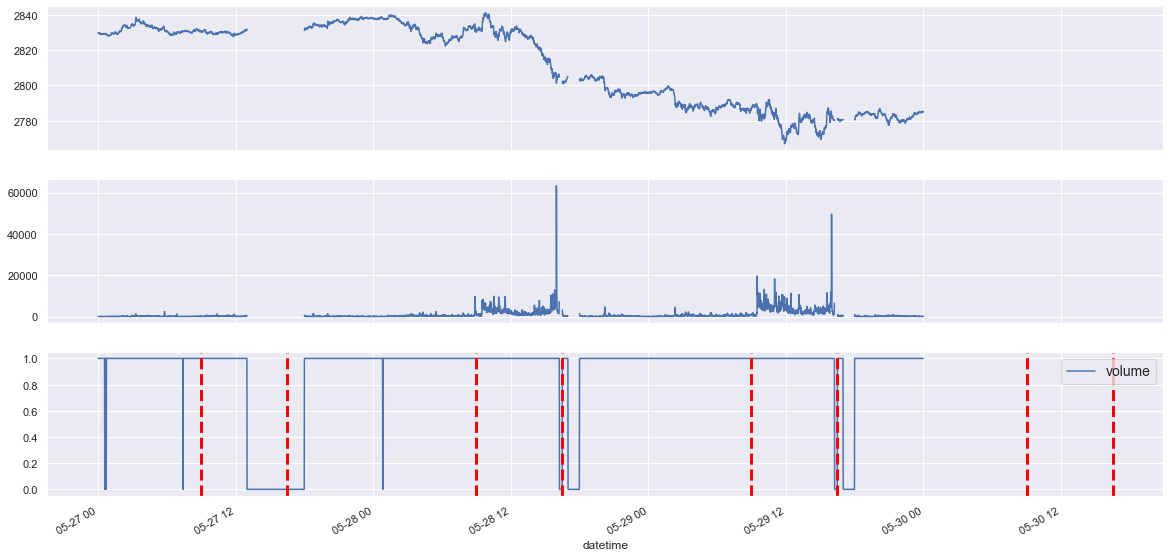

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(
    nrows=3, ncols=1, sharex=True, figsize=(20, 10)
)

df_tmp = df_kibot.resample("1T").mean()

a = pd.Timestamp("2019-05-27 00:00:00")
# a = pd.Timestamp("2019-05-29 00:00:00")
# a = pd.Timestamp("2019-06-02 00:00:00")
print(a, a.day_name())

# b = a + pd.DateOffset(14)
# b = a + pd.DateOffset(7)
b = a + pd.DateOffset(3)
# b = a + pd.DateOffset(1)
print(b, b.day_name())

df_tmp = df_tmp[a:b][["close", "volume"]]
print(
    "samples=%d [%s, %s]" % (df_tmp.shape[0], df_tmp.index[0], df_tmp.index[-1])
)

dates = sorted(list(set(df_tmp.index.date)))  # .unique()
for date in dates:
    print(date, pd.Timestamp(date).day_name())

df_tmp = df_tmp.resample("1T").mean()
df_tmp["close"].plot(ax=ax1)
df_tmp["volume"].plot(ax=ax2)
print(
    "samples=%d [%s, %s]" % (df_tmp.shape[0], df_tmp.index[0], df_tmp.index[-1])
)

#
# df_tmp2 = df_tmp.resample("1T").mean()
# print("samples=%d [%s, %s]" % (df_tmp2.shape[0], df_tmp2.index[0], df_tmp2.index[-1]))

# support = ~pd.isnull(df_tmp["close"])
support = ~pd.isnull(df_tmp["volume"])
print(support[~support].head())
print("no support=", (~support[~support]).sum())
print("with support=", support[support].sum())
pd.DataFrame(1.0 * support).plot(ax=ax3)

for date in dates:
    for h, m in ((9, 0), (16, 30)):
        date_tmp = datetime.datetime.combine(date, datetime.time(h, m))
        date_tmp = pd.Timestamp(date_tmp).tz_localize(tz="America/New_York")
        plt.axvline(date_tmp, color="red", linestyle="--", linewidth=3)

# IB

In [13]:
import ib_insync

ib = imidegaut.ib_connect(1)

Connecting to 127.0.0.1:7497 with clientId 1...
Connected
Logged on to server version 152
API connection ready
Warning 2104, reqId -1: Market data farm connection is OK:usfarm.nj
Warning 2104, reqId -1: Market data farm connection is OK:eufarm
Warning 2104, reqId -1: Market data farm connection is OK:usfuture
Warning 2104, reqId -1: Market data farm connection is OK:cashfarm
Warning 2104, reqId -1: Market data farm connection is OK:usfarm
Warning 2106, reqId -1: HMDS data farm connection is OK:ushmds
Warning 2158, reqId -1: Sec-def data farm connection is OK:secdefil
position: Position(account='DU3235841', contract=Forex('EURUSD', conId=12087792, localSymbol='EUR.USD', tradingClass='EUR.USD'), position=-3900.0, avgCost=1.2093013)
updatePortfolio: PortfolioItem(contract=Forex('EURUSD', conId=12087792, right='0', primaryExchange='IDEALPRO', localSymbol='EUR.USD', tradingClass='EUR.USD'), position=-3900.0, marketPrice=1.204085, marketValue=-4695.93, averageCost=1.2093013, unrealizedPNL=20

In [37]:
contract = ib_insync.ContFuture("ES", "GLOBEX", "USD")
whatToShow = "TRADES"
barSizeSetting = "1 min"
# barSizeSetting = '1 hour'
useRTH = False

start_ts = pd.Timestamp("2019-05-28 15:00").tz_localize(tz="America/New_York")
end_ts = pd.Timestamp("2019-05-29 15:00").tz_localize(tz="America/New_York")

# file_name = "ES.csv"
# if os.path.exists(file_name):
# df_ib = imidegaut.get_data(ib, contract, start_ts, end_ts, barSizeSetting, whatToShow, useRTH)
# df_ib.to_csv("ES.csv")

durationStr = "1 D"
df_ib = imidegaut.req_historical_data(
    ib, contract, end_ts, durationStr, barSizeSetting, whatToShow, useRTH
)

In [38]:
display(df_ib.head(2))
print(df_ib.index[0], df_ib.index[-1])

display(df_kibot.head(2))
print(df_kibot.index[0], df_kibot.index[-1])

,open,high,low,close,volume,average,barCount
date,,,,,,,
2019-05-28 18:00:00-04:00,2804.25,2805.25,2802.25,2803.5,1398,2803.700,322
2019-05-28 18:01:00-04:00,2803.50,2804.00,2803.25,2803.5,322,2803.725,86


2019-05-28 18:00:00-04:00 2019-05-29 14:59:00-04:00


,open,high,low,close,volume
datetime,,,,,
2009-09-27 18:00:00-04:00,1042.25,1043.25,1042.25,1043.00,1354
2009-09-27 18:01:00-04:00,1043.25,1043.50,1042.75,1042.75,778


2009-09-27 18:00:00-04:00 2019-07-19 16:59:00-04:00


# Compare

In [93]:
target_col = "close"
# target_col = "open"
# target_col = "high"
# target_col = "volume"

updatePortfolio: PortfolioItem(contract=Forex('EURUSD', conId=12087792, right='0', primaryExchange='IDEALPRO', localSymbol='EUR.USD', tradingClass='EUR.USD'), position=-3900.0, marketPrice=1.204425, marketValue=-4697.26, averageCost=1.2093013, unrealizedPNL=19.02, realizedPNL=0.0, account='DU3235841')
updatePortfolio: PortfolioItem(contract=Forex('EURUSD', conId=12087792, right='0', primaryExchange='IDEALPRO', localSymbol='EUR.USD', tradingClass='EUR.USD'), position=-3900.0, marketPrice=1.20456005, marketValue=-4697.78, averageCost=1.2093013, unrealizedPNL=18.49, realizedPNL=0.0, account='DU3235841')
updatePortfolio: PortfolioItem(contract=Forex('EURUSD', conId=12087792, right='0', primaryExchange='IDEALPRO', localSymbol='EUR.USD', tradingClass='EUR.USD'), position=-3900.0, marketPrice=1.20441495, marketValue=-4697.22, averageCost=1.2093013, unrealizedPNL=19.06, realizedPNL=0.0, account='DU3235841')
updatePortfolio: PortfolioItem(contract=Forex('EURUSD', conId=12087792, right='0', prim

In [88]:
if True:
    print_df(df_ib, n=1)
    print_df(df_kibot, n=1)

shape= (1260, 7)


,open,high,low,close,volume,average,barCount
date,,,,,,,
2019-05-28 18:00:00-04:00,2804.25,2805.25,2802.25,2803.5,1398,2803.7,322


,open,high,low,close,volume,average,barCount
date,,,,,,,
2019-05-29 14:59:00-04:00,2774.0,2774.5,2773.75,2774.25,1611,2774.125,212


shape= (3413857, 5)


,open,high,low,close,volume
datetime,,,,,
2009-09-27 18:00:00-04:00,1042.25,1043.25,1042.25,1043.0,1354


,open,high,low,close,volume
datetime,,,,,
2019-07-19 16:59:00-04:00,2971.75,2971.75,2969.5,2971.0,2338


,open_ib,high_ib,low_ib,close_ib,volume_ib,average_ib,barCount_ib,open_kibot,high_kibot,low_kibot,close_kibot,volume_kibot
2019-05-28 18:00:00-04:00,2804.25,2805.25,2802.25,2803.5,1398,2803.7,322,2804.25,2805.25,2802.25,2803.5,1398


,volume_ib,volume_kibot
2019-05-28 18:00:00-04:00,1398,1398
2019-05-28 18:01:00-04:00,322,322
2019-05-28 18:02:00-04:00,425,425
2019-05-28 18:03:00-04:00,393,393
2019-05-28 18:04:00-04:00,341,341
2019-05-28 18:05:00-04:00,150,150
2019-05-28 18:06:00-04:00,102,102
2019-05-28 18:07:00-04:00,77,77
2019-05-28 18:08:00-04:00,125,125
2019-05-28 18:09:00-04:00,86,86


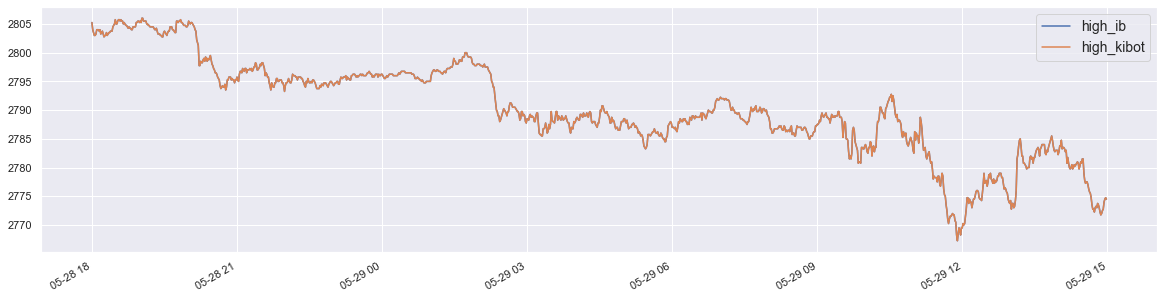

In [89]:
# min_dt = "2013-10-06"
# max_dt = "2013-10-09"
min_dt = start_ts
max_dt = end_ts

#
df_ib_tmp = df_ib.loc[min_dt:max_dt]
df_ib_tmp.columns = ["%s_ib" % c for c in df_ib_tmp.columns]
df_ib_tmp.head()
#
df_kibot_tmp = df_kibot.loc[min_dt:max_dt]
df_kibot_tmp.columns = ["%s_kibot" % c for c in df_kibot_tmp.columns]
df_kibot_tmp.head()

# df = pd.concat([df_ib_tmp, df_kibot_tmp], axis=1, join="outer")
df = pd.concat([df_ib_tmp, df_kibot_tmp], axis=1, join="inner")
display(df.head(1))

# Shift.
df["%s_ib" % target_col] = df["%s_ib" % target_col].shift(0)

# Filter columns.
display(df[cols].head(10))
cols = ["%s_%s" % (target_col, src) for src in "ib kibot".split()]
df[cols].plot()

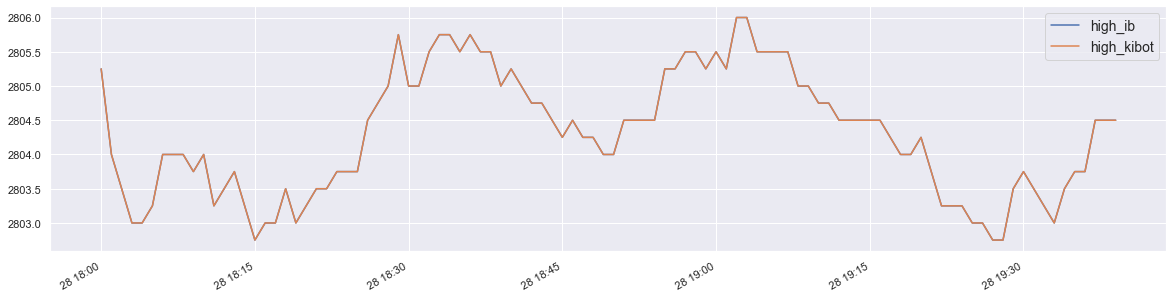

In [90]:
df.iloc[:100][cols].plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa5a7f47ed0>]],
      dtype=object)

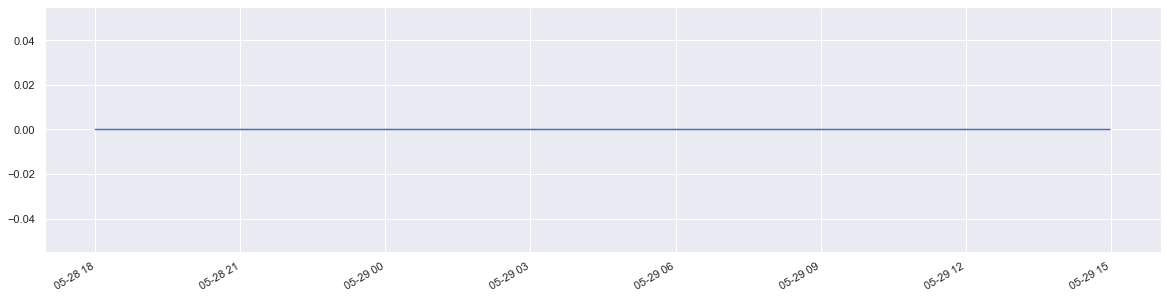

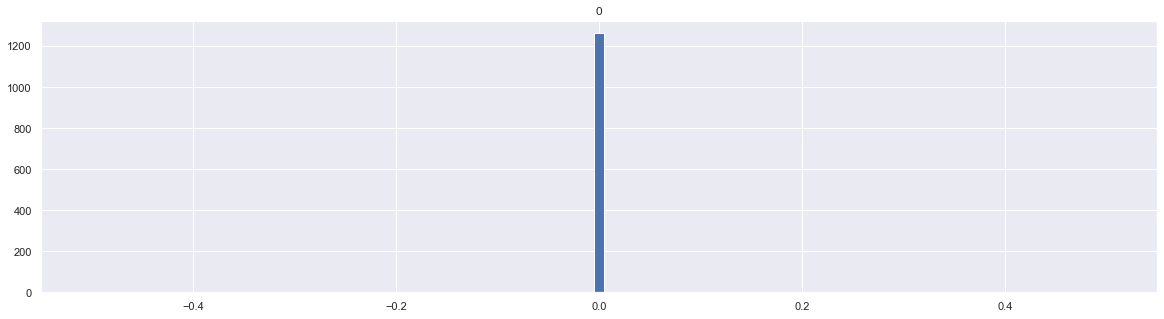

In [91]:
ds1 = "ib"
ds2 = "kibot"
diff = df[target_col + "_" + ds1] - df[target_col + "_" + ds2]

diff.plot()

hpandas.dropna(pd.DataFrame(diff), drop_infs=True).hist(bins=101)

                                 OLS Regression Results                                
Dep. Variable:                high_ib   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                                inf
Date:                Wed, 17 Feb 2021   Prob (F-statistic):                        0.00
Time:                        17:27:01   Log-Likelihood:                             inf
No. Observations:                1260   AIC:                                       -inf
Df Residuals:                    1259   BIC:                                       -inf
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/Users/saggese/.conda/envs/develop/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
/Users/saggese/.conda/envs/develop/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1774: RuntimeWarning: divide by zero encountered in double_scalars
  return self.mse_model/self.mse_resid
/Users/saggese/.conda/envs/develop/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:889: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/saggese/.conda/envs/develop/lib/python3.7/site-packages/statsmodels/stats/stattools.py:46: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)


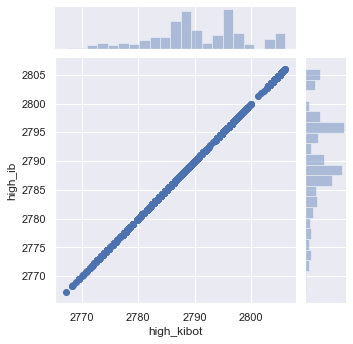

In [92]:
intercept = False
coexplor.ols_regress(
    df,
    target_col + "_" + ds1,
    target_col + "_" + ds2,
    intercept,
    jointplot_=True,
    max_nrows=None,
)